# 🐫 CAMEL VLM Agent with MineDojo and Oasis

In this notebook, we integrate the CAMEL Visual Language Model (VLM) Agent with the MineDojo environment and the Oasis world model to create an interactive agent capable of perceiving and acting within a Minecraft-like world.

Table of contents:
* [Initialize MineDojo](#initialize-minedojo)
* [Initialize the OASIS](#initialize-the-oasis)
* [Get Observation from MineDojo](#get-observation-from-minedojo)
* [Query the VLM Agent with the Observation](#query-the-vlm-agent-with-the-observation)
* [Run single step in the OASIS and MineDojo](#run-single-step-in-the-oasis-and-minedojo)

In [ ]:
import os
import json
import pprint
from getpass import getpass
import matplotlib.pyplot as plt
# Prompt for the API key securely
os.environ["OPENAI_API_KEY"] = "PUT YOUR API HERE"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
from camel.agents import ChatAgent
from camel.configs import ChatGPTConfig
from camel.messages import BaseMessage
from camel.types import ModelType, ModelPlatformType
from camel.types.enums import RoleType
from camel.models import ModelFactory

# Import Agent ActionInterface
from agent.actions import ActionInterface

action_prompts = ActionInterface.get_actions_prompt()

sys_msg = BaseMessage.make_assistant_message(
    role_name="Assistant",
    content=f"You're an agent doing tasks in MineCraft environment. Here are your actions you can call:\n```{action_prompts}```\n",
)


# Set model
model=ModelFactory.create(
    model_platform=ModelPlatformType.OPENAI,
    model_type=ModelType.GPT_4O,
    model_config_dict=ChatGPTConfig(temperature=0.6).as_dict(),
)

# Set agent
vlm_agent = ChatAgent(
    sys_msg,
    model=model
)

## Initialize MineDojo 

In [26]:
import minedojo
import numpy as np
from PIL import Image

# Get all available task ids
all_ids: list[str] = minedojo.tasks.ALL_TASK_IDS
print(all_ids)

['combat_enderman_end_leather_armors_wooden_sword_shield', 'combat_enderman_end_iron_armors_wooden_sword_shield', 'combat_enderman_end_diamond_armors_wooden_sword_shield', 'combat_enderman_end_leather_armors_iron_sword_shield', 'combat_enderman_end_iron_armors_iron_sword_shield', 'combat_enderman_end_diamond_armors_iron_sword_shield', 'combat_enderman_end_leather_armors_diamond_sword_shield', 'combat_enderman_end_iron_armors_diamond_sword_shield', 'combat_enderman_end_diamond_armors_diamond_sword_shield', 'combat_shulker_end_leather_armors_wooden_sword_shield', 'combat_shulker_end_iron_armors_wooden_sword_shield', 'combat_shulker_end_diamond_armors_wooden_sword_shield', 'combat_endermite_end_leather_armors_wooden_sword_shield', 'combat_endermite_end_iron_armors_wooden_sword_shield', 'combat_endermite_end_diamond_armors_wooden_sword_shield', 'combat_shulker_end_leather_armors_iron_sword_shield', 'combat_shulker_end_iron_armors_iron_sword_shield', 'combat_shulker_end_diamond_armors_iron_

In [27]:
# Add MINEDOJO_HEADLESS=1 to your environment variables to run this script headless
os.environ["MINEDOJO_HEADLESS"] = "1" 
# task_id = "harvest_1_log"
task_id = "combat_zombie_forest_iron_armors_iron_sword_shield"

env = minedojo.make(
    task_id=task_id,
    image_size=(288, 512),
    world_seed=0,
    seed=42,
)
task_prompt, task_guidance = minedojo.tasks.ALL_PROGRAMMATIC_TASK_INSTRUCTIONS['harvest_1_log']
print('task_prompt:', task_prompt)
print('task_guidance:', task_guidance)

print(f"[INFO] Create a task with prompt: {env.task_prompt}")

task_prompt: obtain log
task_guidance: 1. Find a tree.
2. Cut the tree down with an axe.
3. Collect the logs that appear.
[INFO] Create a task with prompt: combat a zombie in night forest with a iron sword, shield, and a full suite of iron armors


/home/cjunting/data/miniforge3/envs/alpha_craft/lib/python3.9/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/home/cjunting/data/miniforge3/envs/alpha_craft/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


## Initialize the OASIS 

Please refer to [open-oasis](open-oasis/README.md) for oasis model download. 

In [ ]:
import torch
from open_oasis.world_model import WorldModel

# oasis_ckpt = "path/to/oasis_checkpoint.pt"
# vae_ckpt = "path/to/vae_checkpoint.pt"

oasis_ckpt="/data2/cjunting/.cache/huggingface/hub/models--Etched--oasis-500m/snapshots/4ca7d2d811f4f0c6fd1d5719bf83f14af3446c0c/oasis500m.safetensors"
vae_ckpt="/data2/cjunting/.cache/huggingface/hub/models--Etched--oasis-500m/snapshots/4ca7d2d811f4f0c6fd1d5719bf83f14af3446c0c/vit-l-20.safetensors"

if 'world_model' not in locals(): 
    world_model = WorldModel(
        oasis_ckpt=oasis_ckpt,
        vae_ckpt=vae_ckpt,
        num_frames=32,
        n_prompt_frames=1,
        ddim_steps=10,
        fps=20,
        scaling_factor=0.07843137255,
        max_noise_level=1000,
        noise_abs_max=20,
        stabilization_level=15,
        seed=0,
        device="cuda:3"
    )

Loading Oasis-500M from /data2/cjunting/.cache/huggingface/hub/models--Etched--oasis-500m/snapshots/4ca7d2d811f4f0c6fd1d5719bf83f14af3446c0c/oasis500m.safetensors...
Loading ViT-VAE-L/20 from /data2/cjunting/.cache/huggingface/hub/models--Etched--oasis-500m/snapshots/4ca7d2d811f4f0c6fd1d5719bf83f14af3446c0c/vit-l-20.safetensors...


## Get Observation from MineDojo

In [29]:
task_prompt, task_guidance = minedojo.tasks.ALL_PROGRAMMATIC_TASK_INSTRUCTIONS['harvest_1_log']
print('task_prompt:', task_prompt)
print('task_guidance:', task_guidance)

print(f"[INFO] Create a task with prompt: {env.task_prompt}")

obs = env.reset()

obs_img = np.array(obs['rgb'])
obs_img = np.transpose(obs_img, (1, 2, 0))


task_prompt: obtain log
task_guidance: 1. Find a tree.
2. Cut the tree down with an axe.
3. Collect the logs that appear.
[INFO] Create a task with prompt: combat a zombie in night forest with a iron sword, shield, and a full suite of iron armors


[INFO:minedojo.tasks] Loaded 1581 Programmatic tasks, 1560 Creative tasks, and 1 special task: "Playthrough". Totally 3142 tasks loaded.


(-0.5, 511.5, 287.5, -0.5)

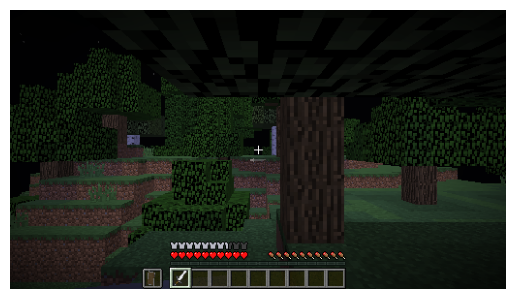

In [41]:
image = Image.fromarray(obs_img.astype('uint8'))
# show the image
plt.imshow(image)
plt.axis("off")

## Query the VLM Agent with the Observation

In [49]:
# reset the agent for this demo
vlm_agent.reset()
vlm_agent.memory.get_context()

([{'role': 'system',
   'content': 'You\'re an agent doing tasks in MineCraft environment. Here are your actions you can call:\n```{\'forward_backward_action\': \'\\n    Forward and Backward Action\\n\\n    Description:\\n        Controls forward and backward movement.\\n\\n    Input Arguments:\\n        action (int):\\n            0 - noop\\n            1 - forward\\n            2 - back\\n\\n    Returns:\\n        int: Validated action value.\\n\\n    Raises:\\n        ValueError: If action is not in [0, 1, 2].\\n    \', \'move_left_right_action\': \'\\n    Move Left and Right Action\\n\\n    Description:\\n        Controls left and right movement.\\n\\n    Input Arguments:\\n        action (int):\\n            0 - noop\\n            1 - move left\\n            2 - move right\\n\\n    Returns:\\n        int: Validated action value.\\n\\n    Raises:\\n        ValueError: If action is not in [0, 1, 2].\\n    \', \'jump_sneak_sprint_action\': \'\\n    Jump, Sneak, and Sprint Action\\n\\

In [50]:
import io
# Convert the image to a PIL.Image

img = Image.fromarray(obs_img.astype('uint8'))
img = img.convert("RGBA")
buffer = io.BytesIO()
img.save(buffer, format="PNG")
buffer.seek(0)
img = Image.open(buffer)


# Create the user message
user_msg = BaseMessage.make_user_message(
    role_name="User",
    content=(
        "Please generate actions based on the following descriptions.\n"
        "Output the actions as a JSON dictionary with the action names as keys and the action values as specified.\n\n"
        f"Your task is {task_prompt}\n"
        f"Task Guidance: {task_guidance}"
    ),
    image_list=[img],  # Include the image if applicable
)

# Get the VLM agent's output
output_message = vlm_agent.step(user_msg)
action_output_str = output_message.msg.content

In [51]:
pprint.pprint(output_message.msg.content)

('```json\n'
 '{\n'
 '    "forward_backward_action": 1,\n'
 '    "move_left_right_action": 0,\n'
 '    "jump_sneak_sprint_action": 0,\n'
 '    "camera_delta_pitch_action": 12,\n'
 '    "camera_delta_yaw_action": 12,\n'
 '    "functional_action": 5,\n'
 '    "equip_place_destroy_argument_action": 0,\n'
 '    "functional_action": 3,\n'
 '    "equip_place_destroy_argument_action": 0,\n'
 '    "forward_backward_action": 1,\n'
 '    "functional_action": 1\n'
 '}\n'
 '```')


In [52]:
# NOTE: There are still some efforts to tune the prompting for action generation
# FIXME: better output format instructions and more robust action parsing
# Now we just use a simple format for the action output
# The agent is expected to generate a MineDojo action dictionary:
# {
#     "forward_backward_action": "1",
#     "jump_sneak_sprint_action": "1",
#     "camera_delta_pitch_action": "12",
#     "camera_delta_yaw_action": "12",
#     "functional_action": "1",
#     ...
# }

def parse_action_output(action_output_str):
    # Remove the ```json and ``` from the string
    action_output_str = action_output_str.strip('```json\n').strip('\n```')
    # Parse the JSON string to a dictionary
    action_dict = json.loads(action_output_str)
    return action_dict

# Example usage
action_dict = parse_action_output(action_output_str)
print(action_dict)

{'forward_backward_action': 1, 'move_left_right_action': 0, 'jump_sneak_sprint_action': 0, 'camera_delta_pitch_action': 12, 'camera_delta_yaw_action': 12, 'functional_action': 1, 'equip_place_destroy_argument_action': 0}


In [53]:
# action_dict = {
#     "forward_backward_action": "1",
#     "jump_sneak_sprint_action": "1",
# }

# Initialize ActionInterface with the parsed actions
action_interface = ActionInterface(actions=action_dict)

In [55]:
# Please refer to https://docs.minedojo.org/sections/core_api/action_space.html for full action space details
# Please refer to [actions](./agent/actions.py) for the action prompt

# Here are all the functions you can call:
import pprint
for key, value in action_prompts.items():
    print(f"{key}: {value}")

forward_backward_action: 
    Forward and Backward Action

    Description:
        Controls forward and backward movement.

    Input Arguments:
        action (int):
            0 - noop
            1 - forward
            2 - back

    Returns:
        int: Validated action value.

    Raises:
        ValueError: If action is not in [0, 1, 2].
    
move_left_right_action: 
    Move Left and Right Action

    Description:
        Controls left and right movement.

    Input Arguments:
        action (int):
            0 - noop
            1 - move left
            2 - move right

    Returns:
        int: Validated action value.

    Raises:
        ValueError: If action is not in [0, 1, 2].
    
jump_sneak_sprint_action: 
    Jump, Sneak, and Sprint Action

    Description:
        Controls jumping, sneaking, and sprinting.

    Input Arguments:
        action (int):
            0 - noop
            1 - jump
            2 - sneak
            3 - sprint

    Returns:
        int: Val

## Run single step in the OASIS and MineDojo

Generating frames: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]


(-0.5, 639.5, 359.5, -0.5)

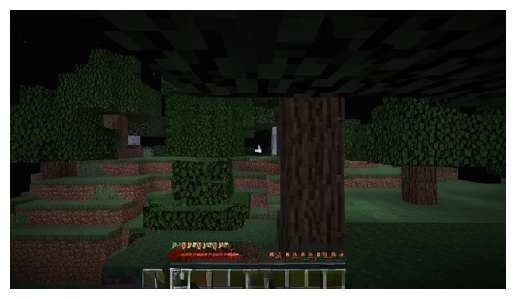

In [56]:
# Use OASIS world model to guess the next state
prompt_tensor = torch.tensor(obs_img).permute(2, 0, 1).unsqueeze(0).float()
# Camera is quantized to [0-79]
# oasis_actions = {"move_forward": 1, "camera": [40,40]}
oasis_actions = action_interface.to_oasis_format()
# By default run the action for 8 frames
next_state = world_model.step_single_action(prompt_tensor, oasis_actions)
# Run 32 frames for this action
# next_state_image = world_model.step_single_action(prompt_tensor, oasis_actions, action_repeats=32, diffusion_frames=32)
# Display the next state
# next_state_img = np.transpose(next_state, (1, 2, 0))
next_state_image = Image.fromarray(next_state)

# show the image
plt.imshow(next_state_image)
plt.axis('off')

In [57]:
oasis_actions

{'forward': 1,
 'back': 0,
 'left': 0,
 'right': 0,
 'camera': [40, 40],
 'jump': 0,
 'sneak': 0,
 'sprint': 0,
 'swapHands': 0,
 'attack': 0,
 'use': 1,
 'pickItem': 0,
 'drop': 0,
 'craft': 0,
 'equip': 0,
 'place': 0,
 'destroy': 0,
 'inventory': 0,
 'ESC': 0,
 'hotbar.1': 0,
 'hotbar.2': 0,
 'hotbar.3': 0,
 'hotbar.4': 0,
 'hotbar.5': 0,
 'hotbar.6': 0,
 'hotbar.7': 0,
 'hotbar.8': 0,
 'hotbar.9': 0}

Keys of obs: dict_keys(['rgb', 'inventory', 'equipment', 'life_stats', 'location_stats', 'nearby_tools', 'damage_source', 'voxels', 'masks', 'delta_inv'])


(-0.5, 511.5, 287.5, -0.5)

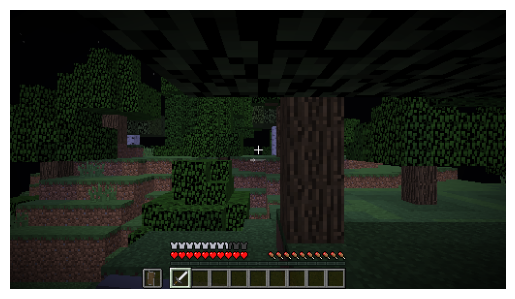

In [58]:
# Run the same action in the minedojo environment
# action = env.action_space.no_op()  # empty action
# action[0] = 1  # move forward
minedojo_actions = action_interface.to_minedojo_format()
obs, reward, done, info = env.step(minedojo_actions)
# print("obs:", obs["rgb"])
print("Keys of obs:", obs.keys())

obs_img = np.array(obs["rgb"])
obs_img = np.transpose(obs_img, (1, 2, 0))

image = Image.fromarray(obs_img.astype("uint8"))
plt.imshow(image)
plt.axis("off")

In [15]:
# Close the environment
env.close()